In [1]:
## General librairies
import pandas as pd
import numpy as np
import _pickle as pickle
import matplotlib.pyplot as plt
import random
import sys
import time
from copy import deepcopy
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import cohen_kappa_score
import optuna
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import json

import dateutil.parser

Using TensorFlow backend.


In [2]:
specs = 'specs.csv'
test = 'test.csv'
train = 'train.csv'
train_labels = 'train_labels.csv'
subs = 'sample_submission_exemple.csv'

In [3]:
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def relative_time(x):
    x1 = []
    for elt in x:
        x1.append((elt-x[0]).item()/1000000000)
    return x1

def categorise(x):
    dico = {}
    count = 0
    for elt in x:
        if not(elt in dico):
            dico[elt] = count
            count += 1
    return dico

def padding( dataset, n):
    d = list(np.zeros(len(dataset)))
    c = 0
    count = 0
    for elt in dataset:
        
        if count % 100 == 0:
            print(count)
        u = elt.shape[0]
        
        if u<200:
            c += 1
        
        if u > n:
            d[count] = elt[-n:]
        else:
            a = np.zeros(((n-u), elt.shape[1])) -1
            elt = np.concatenate([a, elt], axis = 0)
            d[count] = elt
        count += 1
    return d



def build_feature(i,session):
    vect = []
    
    title = session.iloc[0]['title']
    typ = session.iloc[0]['type']
    
    vect.append(session.iloc[0]['game_session'])    ##game_session
    vect.append(session.iloc[0]['installation_id'])   ##installation_id
    vect.append(session.iloc[0]['title'])  ##title
    vect.append(session.iloc[0]['type'])  ##type
    vect.append(session.iloc[0]['world'])  ##world
    vect.append(session.iloc[0]['timestamp'])  ##timestamp
    
    
    ## adding validation data if game or assessment
    if typ == 'Game' or typ == 'Assessment':
        pos = 0
        neg = 0
        for elt in session[session['event_code']==4100]['event_data']:
            a = json.loads(elt)['correct']
#             print(a)
            if a:
                pos+=1
            else:
                neg+=1
            
        if pos+neg ==0:
            acc = -1
        else:
            acc = pos/(pos+neg)
        
#         print(acc)
        if acc == 1:
            acc_class = 3
        elif acc == 0.5:
            acc_class = 2
        elif acc <=0:
            acc_class = 0
        else:
            acc_class = 1
#         print(acc_class)
        vect.append(acc_class)   ## accuracy_group
        vect.append(acc)       ## accuracy
        vect.append(pos)       ## n_positive
        vect.append(neg)       ## n_negative
            
            
    else: 
        vect.append(-1)  ##accuracy_group
        vect.append(-1) ## accuracy_group
        vect.append(-1)  ## n_positive
        vect.append(-1)  ## n_negative
    
    ## Adding features relative to Game, Assessment and activity
    if typ != 'Clip':
        ## Avg time per instruction
        
        st = session['game_time'][session['event_code'] == 3010]
        en = session['game_time'][session['event_code'] == 3110]
        
        s = min(st.shape[0], en.shape[0])
        if s!=0:
            vect.append((en[:s].sum()-st[:s].sum())/s)  ## time per instruction
        else:
            vect.append(-1)  ##time per instruction
        
        ##total_time
        total_time = session['game_time'].max()/1000
        vect.append(total_time)
        
        ##number of actions
        n_action = session[(session['event_code']>=4020)&(session['event_code']<=4080)].shape[0]
        vect.append(n_action)
        
        ## rounds
        n_rounds_st = session[session['event_code']==2020].shape[0]
        n_rounds_en = session[session['event_code']==2030].shape[0]
        
        vect.append(n_rounds_st)
        vect.append(n_rounds_st)
        
        if n_rounds_st != 0:
            vect.append(n_action/n_rounds_st)
            vect.append(total_time/n_rounds_st)
        else:
            vect.append(-1)
            vect.append(-1)
        ## hints
        vect.append(session[session['event_code']==4090].shape[0])
        
    else:
        vect.append(-1)  ## time per instruction
        vect.append(-1)  ##  total time
        vect.append(-1)  ## n_actions
        vect.append(-1)  ## n_rounds_start
        vect.append(-1)  ## n_round end
        vect.append(-1)  ## action per round
        vect.append(-1)  ## time per round
        vect.append(-1)  ## N_hints
    
    if typ == 'Game' or typ == 'Assessment':
        ## feed backs
        
        n_correct_f = session[session['event_code'] == 3121].shape[0]
        n_incorrect_f = session[session['event_code'] == 3120].shape[0]
        
        vect.append(n_correct_f)
        vect.append(n_incorrect_f)
        
        if n_incorrect_f + n_correct_f != 0:
            vect.append(n_correct_f/(n_correct_f+n_incorrect_f))
        else:
            vect.append(0)
        
        if n_correct_f !=0:
            vect.append((session['game_time'][session['event_code'] == 3121].sum()-session['game_time'][session['event_code'] == 3021].sum())/n_correct_f)
        else:
            vect.append(-1)
        
        if n_incorrect_f !=0:
            vect.append((session['game_time'][session['event_code'] == 3120].sum()-session['game_time'][session['event_code'] == 3020].sum())/n_correct_f)
        else:
            vect.append(-1)
    else:
        vect.append(-1)  ## correct_feed
        vect.append(-1)  ## incorrect_feed
        vect.append(-1)  ## acc_feed
        vect.append(-1)  ## time correct feedback
        vect.append(-1)  ## time incorrect feedback
    
    if typ == 'Game':
        vect.append(session[session['event_code'] == 2080].shape[0])
        vect.append(session[session['event_code'] == 2081].shape[0])
        vect.append(session[session['event_code'] == 2060].shape[0])
        vect.append(session[session['event_code'] == 2075].shape[0])
        
        
    else:
        vect.append(-1)  ## n movie
        vect.append(-1)  ## n_skipp movie
        vect.append(-1)  ## tutorial
        vect.append(-1)  ## skipped tutorial
        
    
    
    return vect



#### Loading Data and grouping by game session

#### Train

In [ ]:
df = pd.read_csv(train)
labels = pd.read_csv(train_labels)
vect = df['event_code']
vect[df['event_id'] == '17113b36'] = 4100
df['event_code'] = vect

dataset = list(np.zeros(df['game_session'].unique().shape[0]))

print(df['game_session'].unique().shape[0])

count = 0
for i, session in df.groupby(['game_session']):
#     if count >= 100:
#         break
    line =build_feature(i, session)
#     dataset.append(line)
    dataset[count] = line
    if count % 1000 == 0:
        print(count)
    count += 1

dataset = np.array(dataset)

data = pd.DataFrame(dataset, columns = columns)

save(data, 'data by session')

#### Test

In [ ]:
df = pd.read_csv(test)
vect = df['event_code']
vect[df['event_id'] == '17113b36'] = 4100
df['event_code'] = vect

dataset = list(np.zeros(df['game_session'].unique().shape[0]))

print(df['game_session'].unique().shape[0])

count = 0
for i, session in df.groupby(['game_session']):
#     if count >= 100:
#         break
    line =build_feature(i, session)
#     dataset.append(line)
    dataset[count] = line
    if count % 1000 == 0:
        print(count)
    count += 1

dataset = np.array(dataset)

data = pd.DataFrame(dataset, columns = columns)

save(data, 'data test by session')

#### Getting test labels

In [ ]:
df = load('data by session')
labels = pd.read_csv(train_labels)

ids = df[df['type']=='Assessment']['installation_id'].unique()
df = df[df.installation_id.isin(ids)]
df = df[df.installation_id.isin(labels.installation_id.unique())]

# dtitle = categorise(df['title'])

# df = df.replace({'title' : dtitle})

# save(dtitle, 'dico_title')

df['date'] = df['timestamp'].apply(dateutil.parser.parse)

df = df.sort_values(by = ['date'], ascending =True)

save(df, 'data by session')

In [ ]:
df = load('data test by session')

ids = df[df['type']=='Assessment']['installation_id'].unique()

# dtitle =load('dico_title')

# df = df.replace({'title' : dtitle})

df['date'] = df['timestamp'].apply(dateutil.parser.parse)

df = df.sort_values(by = ['date'], ascending =True)

game_inst = []
for elt in ids:
    df1 = df[df['installation_id']==elt]
    df1 = df1.sort_values(by = ['date'], ascending = True)
    game_inst.append(df1.iloc[-1]['game_session'])
    
save((ids, game_inst), 'test_labels')
save(df, 'data test by session')

#### Adding test session into train

In [ ]:
df = pd.read_csv(test)

test_train = []

df_labels = df[(df['type'] == 'Assessment')&(df['event_code'] == 4100)][['installation_id', 'game_session']].drop_duplicates(subset = ['installation_id', 'game_session'])

df = load('data test by session')

vect = []
vect1 = []
for i in range(df_labels.shape[0]):
    vect.append(df[(df['installation_id'] == df_labels.iloc[i]['installation_id'])&(df['game_session'] == df_labels.iloc[i]['game_session'])]['accuracy_group'].values[0])
    vect1.append(df[(df['installation_id'] == df_labels.iloc[i]['installation_id'])&(df['game_session'] == df_labels.iloc[i]['game_session'])]['accuracy'].values[0])
    
    
    
df_labels['accuracy_group'] = vect
df_labels['accuracy'] = vect1

save(df_labels, 'test labels')

#### Building train dataset


In [100]:
df  = load('data by session')

In [ ]:
df.head()

In [27]:
df.columns

Index(['game_session', 'installation_id', 'title', 'type', 'world',
       'timestamp', 'accuracy_group', 'accuracy', 'n_positive', 'n_negative',
       'time_instruction', 'actions', 'total_time', 'start_rounds',
       'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
       'movies', 'skipped_movie', 'tuto', 'skipped_tuto', 'date'],
      dtype='object')

In [91]:
a = df[df['title'] == 'Bird Measurer (Assessment)']['accuracy'].values.astype('float64')
a = a[(a<15000)&(a>-1)]

a = (a - a.mean())/a.std()

(array([885.,   0.,   2.,   1.,   5.,   4.,   8.,   9.,   6.,  10.,  16.,
         22.,  23.,   5.,  23.,  10.,  45.,   0.,  11.,   0.,  80.,   0.,
         31.,   0.,   0.,  91.,   0.,   0.,  51.,   0.,   0.,   0.,   0.,
        142.,   0.,   0.,   0.,   0.,   0.,   0., 134.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 266.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        320.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        548.]),
 array([-1.04774192, -1.02109685, -0.99445177, -0.9678067 , -0.94116162,
        -0.91451655, -0.88787147, -0.8612264 , -0.83458132, -0.80793625,
        -0.78129118, -0.7546461 , -0.72800103, -0.70135595, -0.67471088,
        -0.6480658 , -0.62142073, -0.59477565, -0.56813058, -0.5414855 ,
        -0.51484043, -0.48

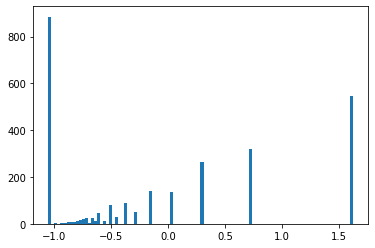

In [93]:
plt.hist(a, bins = 100)

In [134]:
df  = load('data by session')
df1 = load('data test by session')

df = pd.concat([df, df1])

poids = [
    'Lifting Heavy Things','Heavy, Heavier, Heaviest','Pan Balance','Leaf Leader','Happy Camel','Chow Time','Cart Balancer (Assessment)','Egg Dropper (Activity)','Chicken Balancer (Activity)','Chest Sorter (Assessment)'

]

taille = [
    'Rulers','Crystals Rule','Scrub-A-Dub','Dino Drink','Bird Measurer (Assessment)','Cauldron Filler (Assessment)','Bug Measurer (Activity)','Sandcastle Builder (Activity)','All Star Sorting','Mushroom Sorter (Assessment)'
]

volume = [
    'Dino Drink','Dino Dive','Bubble Bath','Cauldron Filler (Assessment)','Watering Hole (Activity)','Sandcastle Builder (Activity)','Bottle Filler (Activity)'
]

matcher = [
    'Balancing Act','Air Show','Scrub-A-Dub','Dino Drink','Dino Dive','Bubble Bath','Pan Balance','Leaf Leader','Chow Time','Cauldron Filler (Assessment)','Cart Balancer (Assessment)','Watering Hole (Activity)','Sandcastle Builder (Activity)','Egg Dropper (Activity)'
]

trier = [
    'Ordering Spheres','Heavy, Heavier, Heaviest','All Star Sorting','Mushroom Sorter (Assessment)','Chest Sorter (Assessment)'
]

mesurer = [
    'Rulers','Crystals Rule','Bubble Bath','Happy Camel','Bird Measurer (Assessment)','Bug Measurer (Activity)','Egg Dropper (Activity)','Chicken Balancer (Activity)','Chest Sorter (Assessment)'
]

feats_to_normalise = ['accuracy', 'n_positive', 'n_negative',
       'time_instruction', 'actions', 'total_time', 'start_rounds',
       'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
       'movies', 'skipped_movie', 'tuto', 'skipped_tuto']

concepts = [poids, taille, volume, matcher, trier, mesurer]
concepts_name = ['poids', 'taille', 'volume', 'matcher', 'trier', 'mesurer']

for c in concepts:
    for tit in c:
        if not(tit in df['title'].unique()):
            print(tit)
            
v = df['title'].values
for i in range(len(concepts)):
    vect = []
    for elt in v:
        if elt in concepts[i]:
            vect.append(1)
        else:
            vect.append(0)
    df[concepts_name[i]] = vect
    
df['is_concept'] = df['poids'] + df['taille'] + df['volume'] + df['matcher'] + df['trier'] + df['mesurer']

df = df[df['is_concept'] > 0]


for elt in df['title'].unique():
    for feats in feats_to_normalise:
        vect = df[df['title'] == elt][feats].values.astype('float64')
        
        m = vect[(vect < 15000)&(vect >= -1)].mean()
        std = vect[(vect < 15000)&(vect >= -1)].std()
        
        df[df['title'] == elt][feats] = (vect - m) / std

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
df.columns

Index(['game_session', 'installation_id', 'title', 'type', 'world',
       'timestamp', 'accuracy_group', 'accuracy', 'n_positive', 'n_negative',
       'time_instruction', 'actions', 'total_time', 'start_rounds',
       'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
       'movies', 'skipped_movie', 'tuto', 'skipped_tuto', 'date', 'poids',
       'taille', 'volume', 'matcher', 'trier', 'mesurer', 'is_concept'],
      dtype='object')

In [135]:
def build_set(df, installation_id, game_session):
    df1 = df[df['installation_id']==installation_id]
    
    df1 = df1.sort_values(by = ['date'], ascending = True)
    date = df1[df1['game_session']==game_session].iloc[0]['date']
    pred_title = df1[df1['game_session']==game_session].iloc[0]['title']
    
    df1 = df1[df1['date'] < date]
    
    vect = [pred_title]
    
    for c in concepts_name:
        df2 = df1[df1[c] == 1]
        
        vect.append(df2[df2['type'] == 'Clip'].shape[0])
        
        vect.append(df2[df2['time_instruction']!= -1]['time_instruction'].values.astype('float64').mean())
        vect.append(df2[df2['time_instruction']!= -1].shape[0])
        
        ## Activity
        df3 = df2[df2['type'] == 'Activity']
        vect.append(df3.shape[0])
        vect.append(df3['start_rounds'].values.astype('float64').mean())
        vect.append(df3['start_rounds'].values.astype('float64').sum())
        
        vect.append(df3['actions'].values.astype('float64').mean())
        vect.append(df3['actions'].values.astype('float64').sum())
        
        ## Games
        df3 = df2[df2['type'] == 'Game']
        vect.append(df3.shape[0])
        vect.append(df3['start_rounds'].values.astype('float64').mean())
        vect.append(df3['start_rounds'].values.astype('float64').sum())
        
        vect.append(df3['actions'].values.astype('float64').mean())
        vect.append(df3['actions'].values.astype('float64').sum())   
        vect.append(df3['acc_feed'].values.astype('float64').mean())
        
        
        if df3.shape[0] >0:
            vect.append(df3['acc_feed'].values.astype('float64').min())
            vect.append(df3['acc_feed'].values.astype('float64').max())
        else:
            vect.append(df3['acc_feed'].values.astype('float64').mean())
            vect.append(df3['acc_feed'].values.astype('float64').mean())
        
        ## Assessments
        df3 = df2[df2['type'] == 'Assessment']
        vect.append(df3.shape[0])

        vect.append(df3['start_rounds'].values.astype('float64').mean())
        vect.append(df3['start_rounds'].values.astype('float64').sum())
        
        vect.append(df3['actions'].values.astype('float64').mean())
        vect.append(df3['actions'].values.astype('float64').sum())   
        
        vect.append(df3['accuracy'].values.astype('float64').mean())
        
        if df3.shape[0]>0:
            vect.append(df3['accuracy'].values.astype('float64').min())
            vect.append(df3['accuracy'].values.astype('float64').max())
            vect.append(df3.iloc[0]['accuracy'])
            vect.append(df3.iloc[-1]['accuracy'])
            vect.append(df3.iloc[0]['accuracy_group'])
            vect.append(df3.iloc[-1]['accuracy_group'])
        else:
            vect.append(df3['accuracy'].values.astype('float64').mean())
            vect.append(df3['accuracy'].values.astype('float64').mean())
            vect.append(df3['accuracy'].values.astype('float64').mean())
            vect.append(df3['accuracy'].values.astype('float64').mean())
            vect.append(df3['accuracy'].values.astype('float64').mean())
            vect.append(df3['accuracy'].values.astype('float64').mean())
    return vect

In [136]:
features = ['n_clips', 'time_inst_mean', 'time_inst_sum',
           'n_activity', 'act_start_round_mean', 'act_start_round_sum', 
            'activity_action_mean', 'activity_action_sum',
            'n_game', 'game_start_round_mean', 'game_start_round_sum', 
            'game_action_mean', 'game_action_sum', 'game_mean_acc','game_min_acc','game_max_acc',
            'n_assessment', 'assessment_start_round_mean', 'assessment_start_round_sum', 
            'assessment_action_mean', 'assessment_action_sum', 'assessment_mean_acc','assessment_min_acc','assessment_max_acc',
            'assessment_first_acc', 'assessment_last_acc','assessment_first_acc_group','assessment_last_acc_group'
           ]

In [137]:
cols = ['pred_title']

for c in concepts_name:
    for f in features:
        cols.append(c+'_'+f)

In [ ]:
clips = ['Welcome to Lost Lagoon!', 'Magma Peak - Level 1',
       'Magma Peak - Level 2', 'Crystal Caves - Level 1',
       'Crystal Caves - Level 2', 'Crystal Caves - Level 3',
       'Tree Top City - Level 1', 'Tree Top City - Level 2',
       'Tree Top City - Level 3', 'Slop Problem',
       'Heavy, Heavier, Heaviest', 'Lifting Heavy Things',
       'Ordering Spheres', '12 Monkeys', 'Balancing Act', 'Costume Box',
       "Pirate's Tale", 'Honey Cake', 'Treasure Map', 'Rulers']

activities = ['Sandcastle Builder (Activity)', 'Watering Hole (Activity)',
       'Bottle Filler (Activity)', 'Fireworks (Activity)',
       'Flower Waterer (Activity)', 'Egg Dropper (Activity)',
       'Chicken Balancer (Activity)', 'Bug Measurer (Activity)']

games = ['All Star Sorting', 'Chow Time', 'Dino Dive', 'Scrub-A-Dub',
       'Bubble Bath', 'Happy Camel', 'Leaf Leader', 'Pan Balance',
       'Dino Drink', 'Crystals Rule', 'Air Show']

assessments = ['Cart Balancer (Assessment)', 'Chest Sorter (Assessment)',
       'Cauldron Filler (Assessment)', 'Mushroom Sorter (Assessment)',
       'Bird Measurer (Assessment)']

def build_set(df, installation_id, game_session):
    df1 = df[df['installation_id']==installation_id]
    
    df1 = df1.sort_values(by = ['date'], ascending = True)
    date = df1[df1['game_session']==game_session].iloc[0]['date']
    pred_title = df1[df1['game_session']==game_session].iloc[0]['title']
    w =  df1[df1['game_session']==game_session].iloc[0]['world']
#     w =  df1[df1['game_session']==game_session].iloc[0]['world']
    
#     df1['game_session'] = game_session
    df1['pred_title'] = pred_title
    df1 = df1[df1['date'] < date]
#     df1 = df1[df1['world'] == w]
    
    vect = []
    
    vect.append(pred_title)
    
    ## Clip
    df2 = df1[df1['type']=='Clip']
    vect.append(df2.shape[0])
    
    ## Activity
    df2 = df1[df1['type']=='Activity']
    
    #n_activity
    vect.append(df2.shape[0])
    # instruction
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())

    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').std())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').std())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').std())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').std())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').std())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').std())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').std())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').std())    

    ## Assessment
    df2 = df1[df1['type']=='Assessment']
    if pred_title in df2['title'].values:
        vect.append(1)
    else:
        vect.append(0)
        
    vect.append(df2.shape[0])
    
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').mean())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').mean())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').mean())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').mean())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').mean())
    
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').std())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').std())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').std())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').std())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').std())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').std())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').std())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').std())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').std())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').std())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').std())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').std())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').std())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').std())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').std())
    
    ## Games
    df2 = df1[df1['type']=='Game']
    vect.append(df2.shape[0])
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').mean())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').mean())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').mean())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').mean())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').mean())
    vect.append(df2[df2['movies']!=-1]['movies'].values.astype('float32').sum())
    vect.append(df2[df2['skipped_movie']!=-1]['skipped_movie'].values.astype('float32').sum())
    vect.append(df2[df2['tuto']!=-1]['tuto'].values.astype('float32').sum())
    vect.append(df2[df2['skipped_tuto']!=-1]['skipped_tuto'].values.astype('float32').mean())
    
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').std())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').std())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').std())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').std())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').std())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').std())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').std())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').std())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').std())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').std())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').std())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').std())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').std())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').std())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').std())
    vect.append(df2[df2['movies']!=-1]['movies'].values.astype('float32').std())
    vect.append(df2[df2['skipped_movie']!=-1]['skipped_movie'].values.astype('float32').std())
    vect.append(df2[df2['tuto']!=-1]['tuto'].values.astype('float32').std())
    vect.append(df2[df2['skipped_tuto']!=-1]['skipped_tuto'].values.astype('float32').std())
    
    ## Activity done
    for x in titles:
        vect.append( df1[df1['title']==x].shape[0])
    
    t = df1['title'].unique()
    
    
    df1 = df1.drop_duplicates(subset = ['title'], keep = 'last')
    df1.index = df1['title']

    feats_activity = [ 'time_instruction', 'actions', 'total_time', 'start_rounds',
       'end_rounds',  'hints', 'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
       'end_rounds_std',  'hints_std']
    for elt in activities:
        if elt in t:
            temp = list(df1.loc[elt][feats_activity].values.astype('float64'))
            vect.extend(temp)
        else:
            for i in range(len(feats_activity)):
                vect.append(-1)
    
    feats_assessment = ['accuracy_group', 'accuracy', 'n_positive', 'n_negative',
       'time_instruction', 'actions', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
                        'accuracy_group_std', 'accuracy_std', 'n_positive_std', 'n_negative_std',
       'time_instruction_std', 'actions_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std']
    
    for elt in assessments:
        if elt in t:
            temp = list(df1.loc[elt][feats_assessment].values.astype('float64'))
            vect.extend(temp)
        else:
            for i in range(len(feats_assessment)):
                vect.append(-1)
    
    for elt in games:
        if elt == 'Air Show' or elt == 'Pan Balance':
            feats_games = [
                         'accuracy_group', 'accuracy', 'n_positive', 'n_negative',
                       'time_instruction', 'actions', 'total_time', 'start_rounds',
                       'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
                       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
                       'skipped_tuto' ,  'accuracy_group_std', 'accuracy_std', 'n_positive_std', 'n_negative_std',
                       'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
                       'end_rounds_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
                       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std',
                       'skipped_tuto_std'
                        ]
        else:
            feats_games = [
               'time_instruction', 'actions', 'total_time', 'start_rounds',
               'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
               'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
               'skipped_tuto'   , 'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
                       'end_rounds_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
                       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std',
                       'skipped_tuto_std'
                ]
    
        if elt in t:
            temp = list(df1.loc[elt][feats_games].values.astype('float64'))
            vect.extend(temp)
        else:
            for i in range(len(feats_games)):
                vect.append(-1)
    
    
    return vect


In [140]:


labels = pd.read_csv(train_labels)
labels_test = load('test labels')

dataset = list(range(labels.shape[0]))

# df = load('data by session')
for i in tqdm(range(labels.shape[0])):
    if i%100 == 0:
        print(i)
    installation_id = labels.iloc[i]['installation_id']
    game_session = labels.iloc[i]['game_session']
    dataset[i] = build_set(df, installation_id, game_session)

    
# df = load('data test by session')
for i in tqdm(range(labels_test.shape[0])):
    if i%100 == 0:
        print(i)
    installation_id = labels_test.iloc[i]['installation_id']
    game_session = labels_test.iloc[i]['game_session']
    dataset.append(build_set(df, installation_id, game_session))
    
df_data = pd.DataFrame(dataset, columns = cols)

save(df_data, 'smart train dataset')

0


C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900



#### Building test dataset

In [142]:
ids, game_inst = load('test_labels')

dataset = list(range(ids.shape[0]))

for i in tqdm(range(ids.shape[0])):
    if i%100 == 0:
        print(i)
    installation_id = ids[i]
    game_session = game_inst[i]
    dataset[i] = build_set(df, installation_id, game_session)

df_data = pd.DataFrame(dataset, columns = cols)
save(df_data, 'smart test dataset')

0


C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning:

Mean of empty slice.

C:\Users\gabri\Anaconda3\lib

100
200
300
400
500
600
700
800
900



#### Preparing for training

In [ ]:
test_labels.head()

In [152]:
dataset = load('smart train dataset')

X = dataset
# labels = pd.read_csv(train_labels)
labels = load('train_labels')
test_labels = load('test labels')
Y = np.concatenate([labels['accuracy_group'].values.astype('float64'), test_labels['accuracy_group'].values.astype('float64')], axis = 0)
Y1 = np.concatenate([labels['accuracy'].values.astype('float64'), test_labels['accuracy'].values.astype('float64')], axis = 0)
groups = Y1 = np.concatenate([labels['installation_id'].values, test_labels['installation_id'].values], axis = 0)
# y = np_utils.to_categorical(Y)


dtitle = load('dico_title')
X = X.replace({'pred_title': dtitle})
X = X.fillna(-2)


# Y = Y[(X['pred_title']==14).values]
# X = X[X['pred_title']==14]


from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                          np.unique(Y),Y)






In [ ]:
features = X.loc[(X.sum(axis=1) != 0), (X.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]


counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(X[feat_a], X[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [ ]:
reduce_test = load('new test dataset')

dtitle = load('dico_title')
reduce_test = reduce_test.replace({'pred_title': dtitle})
reduce_test = reduce_test.fillna(-1)


from sklearn.metrics import mean_squared_error
def stract_hists(feature, train=X, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre



to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['pred_title','accuracy_group', 'installation_id', 'Assessment accuracy_group', 'session_title']:
        data = X[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if (ajust_factor > 10 or ajust_factor < 0.1) or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

In [ ]:
features = [x for x in features if x not in (to_exclude + to_remove)]
X[features].shape

In [ ]:
save(features, 'feats_to_keep')

In [ ]:
features = load('feats_to_keep')
X = X[features]


In [ ]:
X.head()

In [153]:
X1 = pd.get_dummies(X, columns=["pred_title"], prefix=["title"])
X['title_14'] = X1['title_14']
X['title_27'] = X1['title_27']
X['title_28'] = X1['title_28']
X['title_36'] = X1['title_36']
X['title_24'] = X1['title_24']
# X = X[feats_to_keep]
# X['title_14'] = X1['title_14']
# X['title_27'] = X1['title_27']
# X['title_28'] = X1['title_28']
# X['title_36'] = X1['title_36']
# X['title_24'] = X1['title_24']

X = X.astype('float64')

In [174]:
features = [x for x in X.columns if not('assessment' in x)]

In [176]:
X = X[features]

In [173]:
list(X.columns)

['pred_title',
 'poids_n_clips',
 'poids_time_inst_mean',
 'poids_time_inst_sum',
 'poids_n_activity',
 'poids_act_start_round_mean',
 'poids_act_start_round_sum',
 'poids_activity_action_mean',
 'poids_activity_action_sum',
 'poids_n_game',
 'poids_game_start_round_mean',
 'poids_game_start_round_sum',
 'poids_game_action_mean',
 'poids_game_action_sum',
 'poids_game_mean_acc',
 'poids_game_min_acc',
 'poids_game_max_acc',
 'poids_n_assessment',
 'poids_assessment_start_round_mean',
 'poids_assessment_start_round_sum',
 'poids_assessment_action_mean',
 'poids_assessment_action_sum',
 'poids_assessment_mean_acc',
 'poids_assessment_min_acc',
 'poids_assessment_max_acc',
 'poids_assessment_first_acc',
 'poids_assessment_last_acc',
 'poids_assessment_first_acc_group',
 'poids_assessment_last_acc_group',
 'taille_n_clips',
 'taille_time_inst_mean',
 'taille_time_inst_sum',
 'taille_n_activity',
 'taille_act_start_round_mean',
 'taille_act_start_round_sum',
 'taille_activity_action_mean',


In [ ]:
X.columns[16]

In [ ]:
X.shape

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=43)

In [ ]:
X_train.columns[18]

In [178]:
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
params_lgb = {'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.005,
                'feature_fraction': 0.9,
             'max_depth': 8,
                'lambda_l1': 1,  
                'lambda_l2': 1,
#                 'verbose': 100,
    #             'early_stopping_rounds': 100, 'eval_metric': 'cappa'
                  'categoricals' : [0, 16]
                }
clf = LGBMRegressor(**params_lgb)
clf.fit(X_train, y_train, categorical_feature =['pred_title'], eval_set = (X_test, y_test))


params_ctb = {'loss_function':'RMSE', 
                            'iterations':1000,
                              'learning_rate':0.01,
                            'task_type':"GPU",
                              'depth':8,
                 'verbose' : 100,
                 }

params_xgb ={'colsample_bytree': 0.8,                 
                'learning_rate': 0.01,
                'max_depth': 10,
                'subsample': 1,
                'objective':'reg:squarederror',
                #'eval_metric':'rmse',
                'min_child_weight':3,
                'gamma':0.25,
                'n_estimators':100,
                'n_jobs' : 12,
                'categoricals' : [0]}

# clf = XGBRegressor(**params_xgb)
# clf = CatBoostRegressor(**params_ctb)
# clf.fit(X_train, y_train,cat_features = [0], eval_set = (X_test, y_test))

[1]	valid_0's rmse: 1.26143
[2]	valid_0's rmse: 1.25955
[3]	valid_0's rmse: 1.25769
[4]	valid_0's rmse: 1.25588
[5]	valid_0's rmse: 1.25403
[6]	valid_0's rmse: 1.25222
[7]	valid_0's rmse: 1.2504
[8]	valid_0's rmse: 1.24861
[9]	valid_0's rmse: 1.2468
[10]	valid_0's rmse: 1.24505
[11]	valid_0's rmse: 1.24328
[12]	valid_0's rmse: 1.24156
[13]	valid_0's rmse: 1.23983
[14]	valid_0's rmse: 1.23813
[15]	valid_0's rmse: 1.23642
[16]	valid_0's rmse: 1.23472
[17]	valid_0's rmse: 1.23306
[18]	valid_0's rmse: 1.23143
[19]	valid_0's rmse: 1.22978
[20]	valid_0's rmse: 1.22815
[21]	valid_0's rmse: 1.22655
[22]	valid_0's rmse: 1.22492
[23]	valid_0's rmse: 1.2233
[24]	valid_0's rmse: 1.22172
[25]	valid_0's rmse: 1.22015
[26]	valid_0's rmse: 1.21864
[27]	valid_0's rmse: 1.21708
[28]	valid_0's rmse: 1.21557
[29]	valid_0's rmse: 1.21405
[30]	valid_0's rmse: 1.21253
[31]	valid_0's rmse: 1.21106
[32]	valid_0's rmse: 1.20959
[33]	valid_0's rmse: 1.20814
[34]	valid_0's rmse: 1.20666
[35]	valid_0's rmse: 1.205

[278]	valid_0's rmse: 1.05217
[279]	valid_0's rmse: 1.052
[280]	valid_0's rmse: 1.05177
[281]	valid_0's rmse: 1.05158
[282]	valid_0's rmse: 1.05138
[283]	valid_0's rmse: 1.05118
[284]	valid_0's rmse: 1.05098
[285]	valid_0's rmse: 1.05077
[286]	valid_0's rmse: 1.05055
[287]	valid_0's rmse: 1.05038
[288]	valid_0's rmse: 1.05017
[289]	valid_0's rmse: 1.04996
[290]	valid_0's rmse: 1.04978
[291]	valid_0's rmse: 1.04955
[292]	valid_0's rmse: 1.04937
[293]	valid_0's rmse: 1.04917
[294]	valid_0's rmse: 1.04898
[295]	valid_0's rmse: 1.04873
[296]	valid_0's rmse: 1.04854
[297]	valid_0's rmse: 1.04836
[298]	valid_0's rmse: 1.04818
[299]	valid_0's rmse: 1.04801
[300]	valid_0's rmse: 1.04782
[301]	valid_0's rmse: 1.04762
[302]	valid_0's rmse: 1.04745
[303]	valid_0's rmse: 1.04726
[304]	valid_0's rmse: 1.04707
[305]	valid_0's rmse: 1.04692
[306]	valid_0's rmse: 1.04677
[307]	valid_0's rmse: 1.04664
[308]	valid_0's rmse: 1.04646
[309]	valid_0's rmse: 1.04629
[310]	valid_0's rmse: 1.04611
[311]	valid_

[552]	valid_0's rmse: 1.02409
[553]	valid_0's rmse: 1.02406
[554]	valid_0's rmse: 1.02399
[555]	valid_0's rmse: 1.02393
[556]	valid_0's rmse: 1.02387
[557]	valid_0's rmse: 1.02383
[558]	valid_0's rmse: 1.02377
[559]	valid_0's rmse: 1.02371
[560]	valid_0's rmse: 1.02367
[561]	valid_0's rmse: 1.02363
[562]	valid_0's rmse: 1.02357
[563]	valid_0's rmse: 1.02352
[564]	valid_0's rmse: 1.02349
[565]	valid_0's rmse: 1.02345
[566]	valid_0's rmse: 1.02341
[567]	valid_0's rmse: 1.02337
[568]	valid_0's rmse: 1.02332
[569]	valid_0's rmse: 1.02325
[570]	valid_0's rmse: 1.02319
[571]	valid_0's rmse: 1.02318
[572]	valid_0's rmse: 1.02314
[573]	valid_0's rmse: 1.0231
[574]	valid_0's rmse: 1.02305
[575]	valid_0's rmse: 1.02301
[576]	valid_0's rmse: 1.02295
[577]	valid_0's rmse: 1.0229
[578]	valid_0's rmse: 1.02286
[579]	valid_0's rmse: 1.02281
[580]	valid_0's rmse: 1.02279
[581]	valid_0's rmse: 1.02275
[582]	valid_0's rmse: 1.02272
[583]	valid_0's rmse: 1.02267
[584]	valid_0's rmse: 1.02264
[585]	valid_

[826]	valid_0's rmse: 1.01476
[827]	valid_0's rmse: 1.01473
[828]	valid_0's rmse: 1.0147
[829]	valid_0's rmse: 1.01468
[830]	valid_0's rmse: 1.01466
[831]	valid_0's rmse: 1.01466
[832]	valid_0's rmse: 1.01465
[833]	valid_0's rmse: 1.01462
[834]	valid_0's rmse: 1.0146
[835]	valid_0's rmse: 1.01457
[836]	valid_0's rmse: 1.01455
[837]	valid_0's rmse: 1.01454
[838]	valid_0's rmse: 1.01451
[839]	valid_0's rmse: 1.0145
[840]	valid_0's rmse: 1.01447
[841]	valid_0's rmse: 1.01443
[842]	valid_0's rmse: 1.0144
[843]	valid_0's rmse: 1.01441
[844]	valid_0's rmse: 1.0144
[845]	valid_0's rmse: 1.01439
[846]	valid_0's rmse: 1.01437
[847]	valid_0's rmse: 1.01434
[848]	valid_0's rmse: 1.01431
[849]	valid_0's rmse: 1.01431
[850]	valid_0's rmse: 1.01429
[851]	valid_0's rmse: 1.01427
[852]	valid_0's rmse: 1.01426
[853]	valid_0's rmse: 1.01423
[854]	valid_0's rmse: 1.01423
[855]	valid_0's rmse: 1.01423
[856]	valid_0's rmse: 1.01419
[857]	valid_0's rmse: 1.01415
[858]	valid_0's rmse: 1.01412
[859]	valid_0's

[1096]	valid_0's rmse: 1.0097
[1097]	valid_0's rmse: 1.00969
[1098]	valid_0's rmse: 1.00968
[1099]	valid_0's rmse: 1.00964
[1100]	valid_0's rmse: 1.00962
[1101]	valid_0's rmse: 1.0096
[1102]	valid_0's rmse: 1.0096
[1103]	valid_0's rmse: 1.00958
[1104]	valid_0's rmse: 1.00955
[1105]	valid_0's rmse: 1.00952
[1106]	valid_0's rmse: 1.00951
[1107]	valid_0's rmse: 1.00951
[1108]	valid_0's rmse: 1.00949
[1109]	valid_0's rmse: 1.00947
[1110]	valid_0's rmse: 1.00945
[1111]	valid_0's rmse: 1.00944
[1112]	valid_0's rmse: 1.00942
[1113]	valid_0's rmse: 1.0094
[1114]	valid_0's rmse: 1.00939
[1115]	valid_0's rmse: 1.00937
[1116]	valid_0's rmse: 1.00935
[1117]	valid_0's rmse: 1.00933
[1118]	valid_0's rmse: 1.00931
[1119]	valid_0's rmse: 1.0093
[1120]	valid_0's rmse: 1.00926
[1121]	valid_0's rmse: 1.00925
[1122]	valid_0's rmse: 1.00924
[1123]	valid_0's rmse: 1.00923
[1124]	valid_0's rmse: 1.00923
[1125]	valid_0's rmse: 1.00924
[1126]	valid_0's rmse: 1.00922
[1127]	valid_0's rmse: 1.00921
[1128]	valid_

[1361]	valid_0's rmse: 1.00615
[1362]	valid_0's rmse: 1.00614
[1363]	valid_0's rmse: 1.00613
[1364]	valid_0's rmse: 1.00613
[1365]	valid_0's rmse: 1.00612
[1366]	valid_0's rmse: 1.0061
[1367]	valid_0's rmse: 1.00611
[1368]	valid_0's rmse: 1.00612
[1369]	valid_0's rmse: 1.0061
[1370]	valid_0's rmse: 1.00607
[1371]	valid_0's rmse: 1.00607
[1372]	valid_0's rmse: 1.00606
[1373]	valid_0's rmse: 1.00605
[1374]	valid_0's rmse: 1.00604
[1375]	valid_0's rmse: 1.00603
[1376]	valid_0's rmse: 1.00603
[1377]	valid_0's rmse: 1.006
[1378]	valid_0's rmse: 1.00599
[1379]	valid_0's rmse: 1.00597
[1380]	valid_0's rmse: 1.00597
[1381]	valid_0's rmse: 1.00597
[1382]	valid_0's rmse: 1.00594
[1383]	valid_0's rmse: 1.00593
[1384]	valid_0's rmse: 1.00592
[1385]	valid_0's rmse: 1.0059
[1386]	valid_0's rmse: 1.0059
[1387]	valid_0's rmse: 1.00588
[1388]	valid_0's rmse: 1.00587
[1389]	valid_0's rmse: 1.00586
[1390]	valid_0's rmse: 1.00585
[1391]	valid_0's rmse: 1.00585
[1392]	valid_0's rmse: 1.00585
[1393]	valid_0

[1626]	valid_0's rmse: 1.00378
[1627]	valid_0's rmse: 1.00378
[1628]	valid_0's rmse: 1.00376
[1629]	valid_0's rmse: 1.00376
[1630]	valid_0's rmse: 1.00376
[1631]	valid_0's rmse: 1.00376
[1632]	valid_0's rmse: 1.00375
[1633]	valid_0's rmse: 1.00373
[1634]	valid_0's rmse: 1.00372
[1635]	valid_0's rmse: 1.0037
[1636]	valid_0's rmse: 1.00372
[1637]	valid_0's rmse: 1.00372
[1638]	valid_0's rmse: 1.00372
[1639]	valid_0's rmse: 1.00371
[1640]	valid_0's rmse: 1.00371
[1641]	valid_0's rmse: 1.00371
[1642]	valid_0's rmse: 1.00371
[1643]	valid_0's rmse: 1.00371
[1644]	valid_0's rmse: 1.00372
[1645]	valid_0's rmse: 1.0037
[1646]	valid_0's rmse: 1.0037
[1647]	valid_0's rmse: 1.0037
[1648]	valid_0's rmse: 1.00367
[1649]	valid_0's rmse: 1.00367
[1650]	valid_0's rmse: 1.00367
[1651]	valid_0's rmse: 1.00365
[1652]	valid_0's rmse: 1.00365
[1653]	valid_0's rmse: 1.00364
[1654]	valid_0's rmse: 1.00363
[1655]	valid_0's rmse: 1.00361
[1656]	valid_0's rmse: 1.00359
[1657]	valid_0's rmse: 1.00358
[1658]	valid

[1891]	valid_0's rmse: 1.00208
[1892]	valid_0's rmse: 1.00206
[1893]	valid_0's rmse: 1.00205
[1894]	valid_0's rmse: 1.00205
[1895]	valid_0's rmse: 1.00203
[1896]	valid_0's rmse: 1.00204
[1897]	valid_0's rmse: 1.00205
[1898]	valid_0's rmse: 1.00206
[1899]	valid_0's rmse: 1.00205
[1900]	valid_0's rmse: 1.00203
[1901]	valid_0's rmse: 1.00202
[1902]	valid_0's rmse: 1.00203
[1903]	valid_0's rmse: 1.00204
[1904]	valid_0's rmse: 1.00204
[1905]	valid_0's rmse: 1.00201
[1906]	valid_0's rmse: 1.002
[1907]	valid_0's rmse: 1.00199
[1908]	valid_0's rmse: 1.00199
[1909]	valid_0's rmse: 1.002
[1910]	valid_0's rmse: 1.00199
[1911]	valid_0's rmse: 1.00199
[1912]	valid_0's rmse: 1.00198
[1913]	valid_0's rmse: 1.00198
[1914]	valid_0's rmse: 1.00197
[1915]	valid_0's rmse: 1.00195
[1916]	valid_0's rmse: 1.00194
[1917]	valid_0's rmse: 1.00194
[1918]	valid_0's rmse: 1.00193
[1919]	valid_0's rmse: 1.00193
[1920]	valid_0's rmse: 1.0019
[1921]	valid_0's rmse: 1.00192
[1922]	valid_0's rmse: 1.00191
[1923]	valid_

In [ ]:
from sklearn.ensemble import BaggingRegressor

clf = BaggingRegressor(base_estimator=LGBMRegressor(**params_lgb),max_samples = 0.8, 
                n_estimators=10, random_state=0, oob_score = True, verbose = 1,
                        n_jobs = 12).fit(X_train, y_train, cat_features = [0,18])

In [ ]:
def get_model():
    from sklearn.ensemble import ExtraTreesRegressor
    from mlxtend.regressor import StackingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.svm import SVR
    from catboost import CatBoostClassifier, Pool, CatBoostRegressor
    from lightgbm import LGBMRegressor
    from xgboost import XGBClassifier, XGBRegressor

    params_lgb = {'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.005,
                'feature_fraction': 0.9,
             'max_depth': 8,
                'lambda_l1': 1,  
                'lambda_l2': 1,
#                 'verbose': 100,
    #             'early_stopping_rounds': 100, 'eval_metric': 'cappa'
                  'categoricals' : [0]
                }

    params_ctb = {'loss_function':'RMSE', 
                            'iterations':300,
                              'learning_rate':0.01,
                            'task_type':"GPU",
                              'depth':8,
                 'verbose' : False,
                 }

    params_xgb ={'colsample_bytree': 0.8,                 
                'learning_rate': 0.01,
                'max_depth': 10,
                'subsample': 1,
                'objective':'reg:squarederror',
                #'eval_metric':'rmse',
                'min_child_weight':3,
                'gamma':0.25,
                'n_estimators':100,
                'n_jobs' : 12,
                'categoricals' : [0]}

    params_rf = {
        'n_estimators':100,
        'n_jobs' : 12,
        'max_depth': 10
    }


    params_ada = {
        'n_estimators':100,
        'loss': 'square'
    }

    from mlxtend.regressor import StackingCVRegressor

    lgb = LGBMRegressor(**params_lgb)
    ctb = CatBoostRegressor(**params_ctb)
    etr = ExtraTreesRegressor(bootstrap=True, max_features=0.45, min_samples_leaf=17, min_samples_split=15, n_estimators=100)
    xgb = XGBRegressor(**params_xgb)
    rf = RandomForestRegressor(**params_rf)
    lr = LinearRegression()
    ada = AdaBoostRegressor(**params_ada)

    svr = SVR()

    clf = StackingCVRegressor(regressors=[lgb, ctb, etr, xgb, rf, lr, ada], 
                               meta_regressor=svr, verbose = 1)
    
    return clf

def tres(pred, t):
    pred1 = deepcopy(pred)
    pred1[pred1 >= t[2]] = 3
    pred1[pred1 < t[0]] = 0
    pred1[(pred1>= t[0])&(pred1 < t[1])] = 1
    pred1[(pred1>= t[1])&(pred1 < t[2])] = 2
    return pred1

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
params_lgb = {'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.005,
                'feature_fraction': 0.9,
             'max_depth': 8,
                'lambda_l1': 1,  
                'lambda_l2': 1,
                'verbose': 100,
    #             'early_stopping_rounds': 100, 'eval_metric': 'cappa'
                  'categoricals' : [0]
                }

params_ctb = {'loss_function':'RMSE', 
                            'iterations':1000,
                              'learning_rate':0.01,
                            'task_type':"GPU",
                              'depth':8,
                 'verbose' : 100,
                 }

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GroupKFold
# X = X.values
y = Y

kf =  GroupKFold(n_splits=5)

scores = []

for train_index, test_index in kf.split(X, Y, groups):
#     print("TRAIN:", train_index, "TEST:", test_index)

#     X_train, X_test = X[train_index], X[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     clf = CatBoostRegressor(**params_ctb)
#     clf.fit(X_train, y_train,cat_features = [0,18], eval_set = (X_test, y_test))
    
    clf = LGBMRegressor(**params_lgb)
    clf.fit(X_train, y_train, categorical_feature =[0,18])
    
    import optuna
    def objective(trial, pred = clf.predict(X_train), y_test = y_train):
        x0 = trial.suggest_uniform('x0', pred.min(), pred.max())
        x1 = trial.suggest_uniform('x1', x0,  pred.max())
        x2 = trial.suggest_uniform('x2', x1,  pred.max())

        t = [x0, x1, x2]
        pred1 = tres(pred, t)
        a = cohen_kappa_score(y_test, pred1, weights = 'quadratic')
        print(a)
        return 1-a
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)
    
    t = list(study.best_params.values())
    pred = clf.predict(X_test)
    pred1 = tres(pred, t)



    print(cohen_kappa_score(y_test, pred1, weights = 'quadratic'))
    scores.append(cohen_kappa_score(y_test, pred1, weights = 'quadratic'))

In [ ]:
scores

In [180]:

def tres(pred, t):
    pred1 = deepcopy(pred)
    pred1[pred1 >= t[2]] = 3
    pred1[pred1 < t[0]] = 0
    pred1[(pred1>= t[0])&(pred1 < t[1])] = 1
    pred1[(pred1>= t[1])&(pred1 < t[2])] = 2
    return pred1

def objective(trial, pred = clf.predict(X_train), y_test = y_train):
    x0 = trial.suggest_uniform('x0', pred.min(), pred.max())
    x1 = trial.suggest_uniform('x1', pred.min(),  pred.max())
    x2 = trial.suggest_uniform('x2', pred.min(),  pred.max())

    t = [x0, x1, x2]
    pred1 = tres(pred, t)
    a = cohen_kappa_score(y_test, pred1, weights = 'quadratic')
    print(a)
    return 1-a

study = optuna.create_study()
study.optimize(objective, n_trials=100)

0.16764663687237014


[I 2019-12-28 21:45:24,925] Finished trial#0 resulted in value: 0.8323533631276299. Current best value is 0.8323533631276299 with parameters: {'x0': 0.12847863029074108, 'x1': 2.7176464835016176, 'x2': 2.7103099944943034}.


0.6360819426353006


[I 2019-12-28 21:45:25,173] Finished trial#1 resulted in value: 0.3639180573646994. Current best value is 0.3639180573646994 with parameters: {'x0': 2.84571426544455, 'x1': 0.805527909395664, 'x2': 1.714850771192425}.


0.6019055762835153


[I 2019-12-28 21:45:25,431] Finished trial#2 resulted in value: 0.39809442371648474. Current best value is 0.3639180573646994 with parameters: {'x0': 2.84571426544455, 'x1': 0.805527909395664, 'x2': 1.714850771192425}.


0.6641568827771696


[I 2019-12-28 21:45:25,691] Finished trial#3 resulted in value: 0.33584311722283045. Current best value is 0.33584311722283045 with parameters: {'x0': 1.830192111264023, 'x1': 0.18136920989845695, 'x2': 2.2423211228152757}.


0.2565487320418185


[I 2019-12-28 21:45:25,933] Finished trial#4 resulted in value: 0.7434512679581815. Current best value is 0.33584311722283045 with parameters: {'x0': 1.830192111264023, 'x1': 0.18136920989845695, 'x2': 2.2423211228152757}.


0.6818825127583514


[I 2019-12-28 21:45:26,189] Finished trial#5 resulted in value: 0.31811748724164857. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.16285434522399378


[I 2019-12-28 21:45:26,447] Finished trial#6 resulted in value: 0.8371456547760062. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6323753313786384


[I 2019-12-28 21:45:26,686] Finished trial#7 resulted in value: 0.36762466862136156. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.3574189058395162


[I 2019-12-28 21:45:26,945] Finished trial#8 resulted in value: 0.6425810941604838. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.08143094283093977


[I 2019-12-28 21:45:27,184] Finished trial#9 resulted in value: 0.9185690571690602. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.2062652706161281


[I 2019-12-28 21:45:27,408] Finished trial#10 resulted in value: 0.7937347293838719. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6126123144069795


[I 2019-12-28 21:45:27,650] Finished trial#11 resulted in value: 0.3873876855930205. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6380895677018779


[I 2019-12-28 21:45:27,934] Finished trial#12 resulted in value: 0.36191043229812214. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6587141638834489


[I 2019-12-28 21:45:28,162] Finished trial#13 resulted in value: 0.34128583611655106. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.5260746287726734


[I 2019-12-28 21:45:28,434] Finished trial#14 resulted in value: 0.4739253712273266. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.21737450515113377


[I 2019-12-28 21:45:28,663] Finished trial#15 resulted in value: 0.7826254948488662. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6666388112975962


[I 2019-12-28 21:45:28,928] Finished trial#16 resulted in value: 0.33336118870240383. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.0002632014439106767


[I 2019-12-28 21:45:29,185] Finished trial#17 resulted in value: 0.9997367985560893. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6623331320460433


[I 2019-12-28 21:45:29,421] Finished trial#18 resulted in value: 0.33766686795395673. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.42219001462673367


[I 2019-12-28 21:45:29,705] Finished trial#19 resulted in value: 0.5778099853732663. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.49115357590147013


[I 2019-12-28 21:45:29,934] Finished trial#20 resulted in value: 0.5088464240985299. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6598329089311962


[I 2019-12-28 21:45:30,221] Finished trial#21 resulted in value: 0.34016709106880383. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6254936065669645


[I 2019-12-28 21:45:30,449] Finished trial#22 resulted in value: 0.3745063934330355. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6361664882180607


[I 2019-12-28 21:45:30,699] Finished trial#23 resulted in value: 0.36383351178193934. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.5738674247525138


[I 2019-12-28 21:45:30,999] Finished trial#24 resulted in value: 0.42613257524748616. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6097171114632673


[I 2019-12-28 21:45:31,234] Finished trial#25 resulted in value: 0.39028288853673265. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6467111089198809


[I 2019-12-28 21:45:31,509] Finished trial#26 resulted in value: 0.35328889108011907. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6707540093973275


[I 2019-12-28 21:45:31,745] Finished trial#27 resulted in value: 0.32924599060267246. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.5600122538222725


[I 2019-12-28 21:45:31,993] Finished trial#28 resulted in value: 0.4399877461777275. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.1696116023976736


[I 2019-12-28 21:45:32,233] Finished trial#29 resulted in value: 0.8303883976023264. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.27270956296534565


[I 2019-12-28 21:45:32,513] Finished trial#30 resulted in value: 0.7272904370346543. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6803169205236959


[I 2019-12-28 21:45:32,775] Finished trial#31 resulted in value: 0.31968307947630414. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6516491410714524


[I 2019-12-28 21:45:33,019] Finished trial#32 resulted in value: 0.34835085892854756. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6278473414581112


[I 2019-12-28 21:45:33,263] Finished trial#33 resulted in value: 0.37215265854188884. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6753108620748205


[I 2019-12-28 21:45:33,508] Finished trial#34 resulted in value: 0.3246891379251795. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.5668041807450221


[I 2019-12-28 21:45:33,754] Finished trial#35 resulted in value: 0.43319581925497785. Current best value is 0.31811748724164857 with parameters: {'x0': 1.617164767168839, 'x1': 1.6711264685699654, 'x2': 2.327548721966182}.


0.6860759661441889


[I 2019-12-28 21:45:34,004] Finished trial#36 resulted in value: 0.31392403385581114. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6742506796715948


[I 2019-12-28 21:45:34,264] Finished trial#37 resulted in value: 0.3257493203284052. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6608494243942047


[I 2019-12-28 21:45:34,517] Finished trial#38 resulted in value: 0.3391505756057953. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6450164560761635


[I 2019-12-28 21:45:34,764] Finished trial#39 resulted in value: 0.35498354392383646. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.06567687475031192


[I 2019-12-28 21:45:35,014] Finished trial#40 resulted in value: 0.9343231252496881. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6686794136808835


[I 2019-12-28 21:45:35,261] Finished trial#41 resulted in value: 0.33132058631911654. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.5378958520965512


[I 2019-12-28 21:45:35,515] Finished trial#42 resulted in value: 0.4621041479034488. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6772996297037066


[I 2019-12-28 21:45:35,760] Finished trial#43 resulted in value: 0.3227003702962934. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.5968376180463812


[I 2019-12-28 21:45:36,009] Finished trial#44 resulted in value: 0.40316238195361875. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6836373866959623


[I 2019-12-28 21:45:36,246] Finished trial#45 resulted in value: 0.3163626133040377. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.5486868415646413


[I 2019-12-28 21:45:36,486] Finished trial#46 resulted in value: 0.4513131584353587. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6688710076355122


[I 2019-12-28 21:45:36,729] Finished trial#47 resulted in value: 0.3311289923644878. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.524102244921455


[I 2019-12-28 21:45:36,972] Finished trial#48 resulted in value: 0.47589775507854504. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6378823690235262


[I 2019-12-28 21:45:37,220] Finished trial#49 resulted in value: 0.36211763097647376. Current best value is 0.31392403385581114 with parameters: {'x0': 1.0741421140843626, 'x1': 2.378159457495431, 'x2': 2.059643636104198}.


0.6948160950894954


[I 2019-12-28 21:45:37,461] Finished trial#50 resulted in value: 0.3051839049105046. Current best value is 0.3051839049105046 with parameters: {'x0': 0.9934929268333819, 'x1': 2.0014863551548814, 'x2': 2.1447138375484367}.


0.703040940511017


[I 2019-12-28 21:45:37,708] Finished trial#51 resulted in value: 0.29695905948898305. Current best value is 0.29695905948898305 with parameters: {'x0': 0.9549025826991745, 'x1': 1.9005584867901117, 'x2': 2.2188248157676704}.


0.704853855090702


[I 2019-12-28 21:45:37,952] Finished trial#52 resulted in value: 0.295146144909298. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6200842882635602


[I 2019-12-28 21:45:38,196] Finished trial#53 resulted in value: 0.3799157117364398. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6783153811532612


[I 2019-12-28 21:45:38,454] Finished trial#54 resulted in value: 0.3216846188467388. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6944543764945594


[I 2019-12-28 21:45:38,696] Finished trial#55 resulted in value: 0.30554562350544057. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.694814373416002


[I 2019-12-28 21:45:38,962] Finished trial#56 resulted in value: 0.30518562658399795. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6944962121305935


[I 2019-12-28 21:45:39,209] Finished trial#57 resulted in value: 0.30550378786940646. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6955674865985151


[I 2019-12-28 21:45:39,451] Finished trial#58 resulted in value: 0.3044325134014849. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6554108761319966


[I 2019-12-28 21:45:39,692] Finished trial#59 resulted in value: 0.34458912386800344. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.5500512724764226


[I 2019-12-28 21:45:39,939] Finished trial#60 resulted in value: 0.4499487275235774. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6941795553929377


[I 2019-12-28 21:45:40,185] Finished trial#61 resulted in value: 0.30582044460706226. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.7028343291918062


[I 2019-12-28 21:45:40,431] Finished trial#62 resulted in value: 0.2971656708081938. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.693605716635445


[I 2019-12-28 21:45:40,671] Finished trial#63 resulted in value: 0.306394283364555. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6790660340567133


[I 2019-12-28 21:45:40,923] Finished trial#64 resulted in value: 0.3209339659432867. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6341023605073455


[I 2019-12-28 21:45:41,168] Finished trial#65 resulted in value: 0.3658976394926545. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6790658661293517


[I 2019-12-28 21:45:41,413] Finished trial#66 resulted in value: 0.3209341338706483. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.675470727137666


[I 2019-12-28 21:45:41,661] Finished trial#67 resulted in value: 0.324529272862334. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6194181518159997


[I 2019-12-28 21:45:41,926] Finished trial#68 resulted in value: 0.3805818481840003. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.552901393354924


[I 2019-12-28 21:45:42,175] Finished trial#69 resulted in value: 0.44709860664507595. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.576568175650317


[I 2019-12-28 21:45:42,439] Finished trial#70 resulted in value: 0.42343182434968296. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6759950240800272


[I 2019-12-28 21:45:42,686] Finished trial#71 resulted in value: 0.3240049759199728. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.7008373476261484


[I 2019-12-28 21:45:42,935] Finished trial#72 resulted in value: 0.29916265237385165. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6990386530168786


[I 2019-12-28 21:45:43,187] Finished trial#73 resulted in value: 0.3009613469831214. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6877273191475324


[I 2019-12-28 21:45:43,431] Finished trial#74 resulted in value: 0.3122726808524676. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.670024966519591


[I 2019-12-28 21:45:43,679] Finished trial#75 resulted in value: 0.329975033480409. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6907739975517871


[I 2019-12-28 21:45:43,930] Finished trial#76 resulted in value: 0.30922600244821286. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6687918743087327


[I 2019-12-28 21:45:44,178] Finished trial#77 resulted in value: 0.33120812569126734. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6863854090638029


[I 2019-12-28 21:45:44,423] Finished trial#78 resulted in value: 0.31361459093619715. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.7026896727744703


[I 2019-12-28 21:45:44,675] Finished trial#79 resulted in value: 0.29731032722552975. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6069216549969774


[I 2019-12-28 21:45:44,946] Finished trial#80 resulted in value: 0.39307834500302263. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.7007295803148721


[I 2019-12-28 21:45:45,194] Finished trial#81 resulted in value: 0.2992704196851279. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.699828401845248


[I 2019-12-28 21:45:45,463] Finished trial#82 resulted in value: 0.30017159815475203. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.7027215833680391


[I 2019-12-28 21:45:45,733] Finished trial#83 resulted in value: 0.29727841663196086. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.656241847002942


[I 2019-12-28 21:45:45,983] Finished trial#84 resulted in value: 0.34375815299705803. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.678231008862013


[I 2019-12-28 21:45:46,240] Finished trial#85 resulted in value: 0.32176899113798696. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.37691414346229657


[I 2019-12-28 21:45:46,495] Finished trial#86 resulted in value: 0.6230858565377034. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.0021047913709685284


[I 2019-12-28 21:45:46,745] Finished trial#87 resulted in value: 0.9978952086290315. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6797128394700573


[I 2019-12-28 21:45:47,003] Finished trial#88 resulted in value: 0.32028716052994266. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6468386633587817


[I 2019-12-28 21:45:47,280] Finished trial#89 resulted in value: 0.3531613366412183. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6208742613562401


[I 2019-12-28 21:45:47,561] Finished trial#90 resulted in value: 0.37912573864375987. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.7015272445570936


[I 2019-12-28 21:45:47,810] Finished trial#91 resulted in value: 0.2984727554429064. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6921594611510677


[I 2019-12-28 21:45:48,066] Finished trial#92 resulted in value: 0.30784053884893225. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6992758666080309


[I 2019-12-28 21:45:48,309] Finished trial#93 resulted in value: 0.30072413339196913. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6976883737830604


[I 2019-12-28 21:45:48,556] Finished trial#94 resulted in value: 0.30231162621693963. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.7008010809992604


[I 2019-12-28 21:45:48,798] Finished trial#95 resulted in value: 0.2991989190007396. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6941971376849247


[I 2019-12-28 21:45:49,041] Finished trial#96 resulted in value: 0.30580286231507525. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6790385673643753


[I 2019-12-28 21:45:49,319] Finished trial#97 resulted in value: 0.3209614326356247. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6680803203544441


[I 2019-12-28 21:45:49,574] Finished trial#98 resulted in value: 0.3319196796455559. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


0.6650614561151145


[I 2019-12-28 21:45:49,820] Finished trial#99 resulted in value: 0.33493854388488553. Current best value is 0.295146144909298 with parameters: {'x0': 0.9712692917127995, 'x1': 1.7711454128544017, 'x2': 2.2085807645051583}.


In [ ]:
X_test.columns = new_feats

In [181]:
t = list(study.best_params.values())
pred = clf.predict(X_test)
pred1 = tres(pred, t)



print(cohen_kappa_score(y_test, pred1, weights = 'quadratic'))

0.5838029546179048


{0: 1.2869053028801478, 1: 1.8239855137463965, 2: 2.1405108224059908}
0.5767007637250975


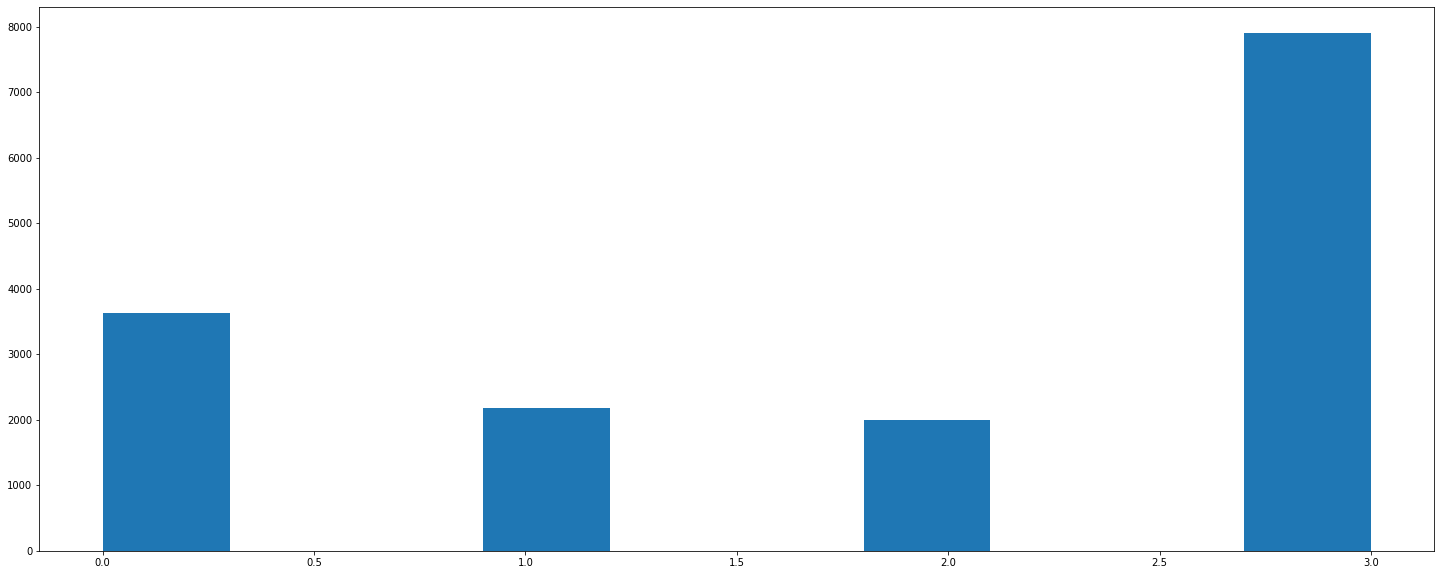

In [182]:
pred = clf.predict(X_test)

from collections import Counter
dist = Counter(y_train)
for k in dist:
    dist[k] /= len(y_train)
plt.hist(y_train)

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, pred)))

print(cohen_kappa_score(y_test, final_pred, weights = 'quadratic'))

In [ ]:
percent

In [ ]:
t

In [ ]:
tres(np.array([1.27]),t)

In [ ]:
plt.hist(pred1)

In [ ]:
plt.hist(tres(clf.predict(X_train), t))

In [ ]:
y_val[1766]

In [ ]:
np.argsort(y_val)

In [ ]:
percent

In [ ]:
plt.hist(y_train[X_train['pred_title'] == 14])

(array([ 908.,    0.,    0.,  544.,    0.,    0.,  497.,    0.,    0.,
        1976.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

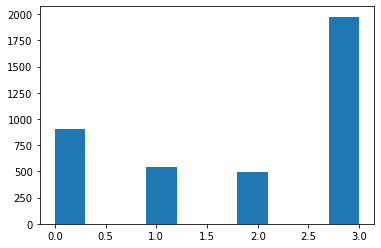

In [162]:
plt.hist(final_pred)

(array([ 809.,    0.,    0.,  346.,    0.,    0., 1235.,    0.,    0.,
        1535.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

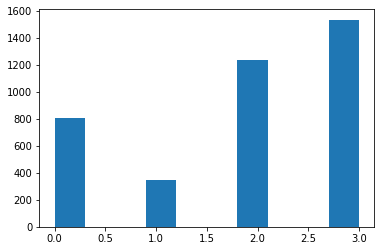

In [159]:
plt.hist(pred1)

In [163]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, final_pred)

array([[ 580,  167,   82,  113],
       [ 161,  114,   94,  160],
       [  56,   64,   74,  251],
       [ 111,  199,  247, 1452]], dtype=int64)

In [ ]:
pred

In [ ]:
y_test

In [ ]:
dataset['Games_accuracy'].value_counts()

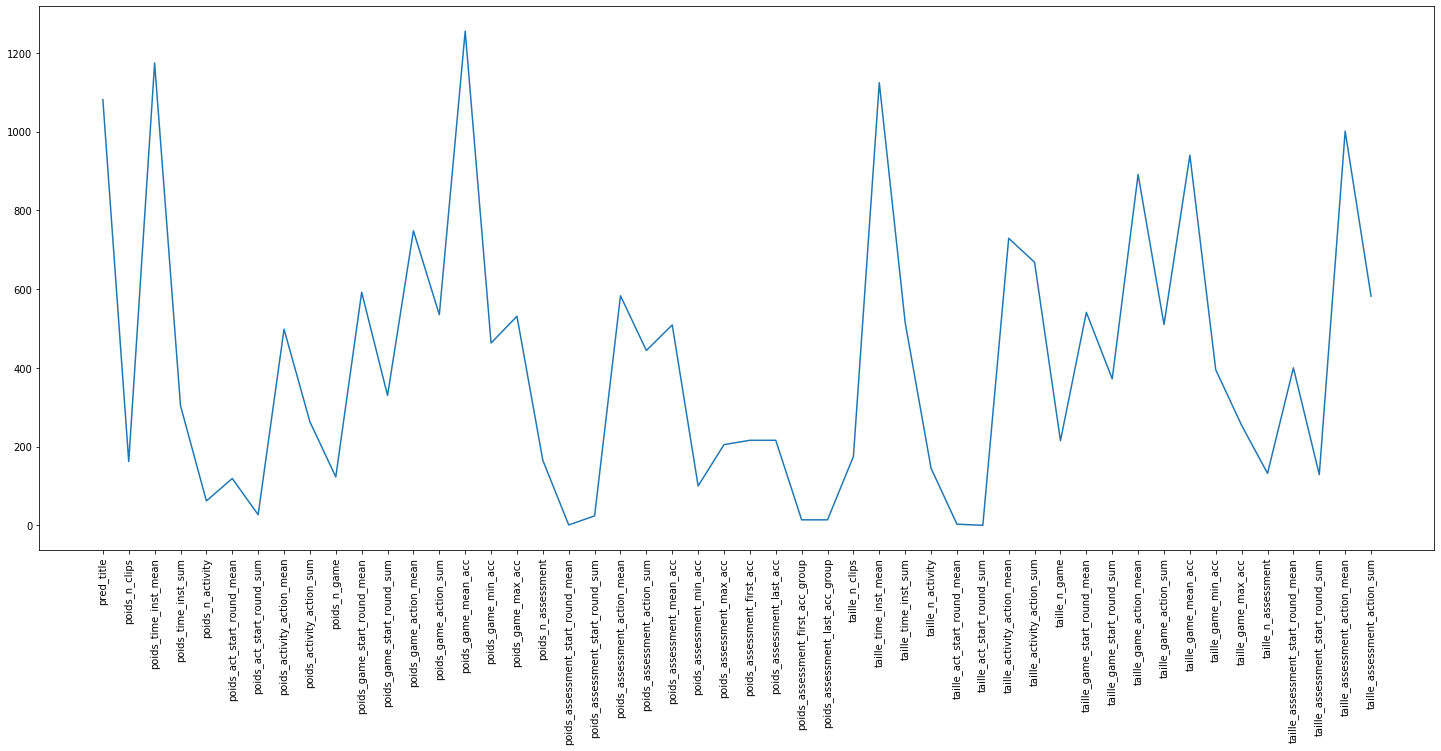

In [168]:
plt.rcParams["figure.figsize"] = (25,10)
ind0 = 0
ind1 = 50
plt.plot(X.columns[ind0:ind1], clf.feature_importances_[ind0:ind1])
plt.xticks(X.columns[ind0:ind1], X.columns[ind0:ind1], rotation = 'vertical')
plt.savefig('features.png')


In [ ]:
dir(clf)

In [169]:
# l = []
# for i in range(len(clf.feature_names_)):
#     l.append([clf.feature_importances_[i], clf.feature_names_[i]])

l = []
for i in range(len(X.columns)):
    l.append([clf.feature_importances_[i], X.columns[i]])


In [170]:
l.sort(reverse = True)

In [171]:
l = np.array(l)

In [172]:
list(l)

[array(['1440', 'matcher_game_mean_acc'], dtype='<U35'),
 array(['1255', 'poids_game_mean_acc'], dtype='<U35'),
 array(['1238', 'matcher_time_inst_mean'], dtype='<U35'),
 array(['1174', 'poids_time_inst_mean'], dtype='<U35'),
 array(['1124', 'taille_time_inst_mean'], dtype='<U35'),
 array(['1117', 'mesurer_time_inst_mean'], dtype='<U35'),
 array(['1081', 'pred_title'], dtype='<U35'),
 array(['1016', 'trier_time_inst_mean'], dtype='<U35'),
 array(['1001', 'taille_assessment_action_mean'], dtype='<U35'),
 array(['977', 'volume_time_inst_mean'], dtype='<U35'),
 array(['955', 'matcher_game_action_mean'], dtype='<U35'),
 array(['940', 'taille_game_mean_acc'], dtype='<U35'),
 array(['936', 'matcher_assessment_action_mean'], dtype='<U35'),
 array(['891', 'taille_game_action_mean'], dtype='<U35'),
 array(['875', 'matcher_activity_action_mean'], dtype='<U35'),
 array(['850', 'matcher_game_start_round_mean'], dtype='<U35'),
 array(['826', 'taille_assessment_mean_acc'], dtype='<U35'),
 array(['78

In [ ]:
l[:,0].astype('float64').sum()

In [ ]:
p = 0.1
feats_to_keep = l[l[:,0].astype('float64') > p,1]
l[l[:,0].astype('float64') > p,0].astype('float64').sum()

In [ ]:
feats_to_keep.shape

## Test 

In [187]:
ids, game_inst = load('test_labels')
df_data = load('smart test dataset')
# df_data = ajusted_test
df_data = df_data.replace({'pred_title': dtitle})
df_data =df_data.fillna(-2)


In [188]:
X1 = pd.get_dummies(df_data, columns=["pred_title"], prefix=["title"])
df_data['title_14'] = X1['title_14']
df_data['title_27'] = X1['title_27']
df_data['title_28'] = X1['title_28']
df_data['title_36'] = X1['title_36']
df_data['title_24'] = X1['title_24']

df_data = df_data.astype('float64')

df_data = df_data[features]

In [189]:
pred = clf.predict(df_data)
# pred = pred.reshape((pred.shape[0])).astype(int)

In [190]:
pred

array([ 1.81549613,  2.10122925,  0.85014391,  0.46212299,  0.65341139,
        2.37252602,  2.76638524,  2.21918519,  2.44662523,  2.06519301,
        2.46364321,  0.46144084,  1.28747396,  1.49814846,  0.48497701,
        0.21933067,  2.19509306,  2.21918519,  1.34421756,  2.67887907,
        2.31212616,  2.34634278,  2.37737061,  1.30518003,  1.49813953,
        2.18350585,  2.68748506,  2.32353201,  2.02322669,  1.33899491,
        0.29289556,  2.20627432,  2.06738534,  1.61982658,  2.24996732,
        2.48710801,  0.80903903,  2.53913074,  2.60926803,  2.42547725,
        2.67753862,  2.18350585,  2.21960749,  0.42301845,  2.56698939,
        0.88299116,  2.68118626,  2.34764777,  2.79089518,  1.05857601,
        2.36226626,  2.18069435,  1.61764034,  1.87548988,  2.63017734,
        2.4479589 ,  1.39478673,  2.53319329,  2.40753322,  2.60396038,
        2.56646777,  2.17153293,  2.21918519,  2.54049009,  1.046119  ,
        2.59268569,  2.34053255,  2.09935585,  2.72211127,  2.49

{0: 1.5692829977115323, 1: 1.9881290808802548, 2: 2.183505854802488}


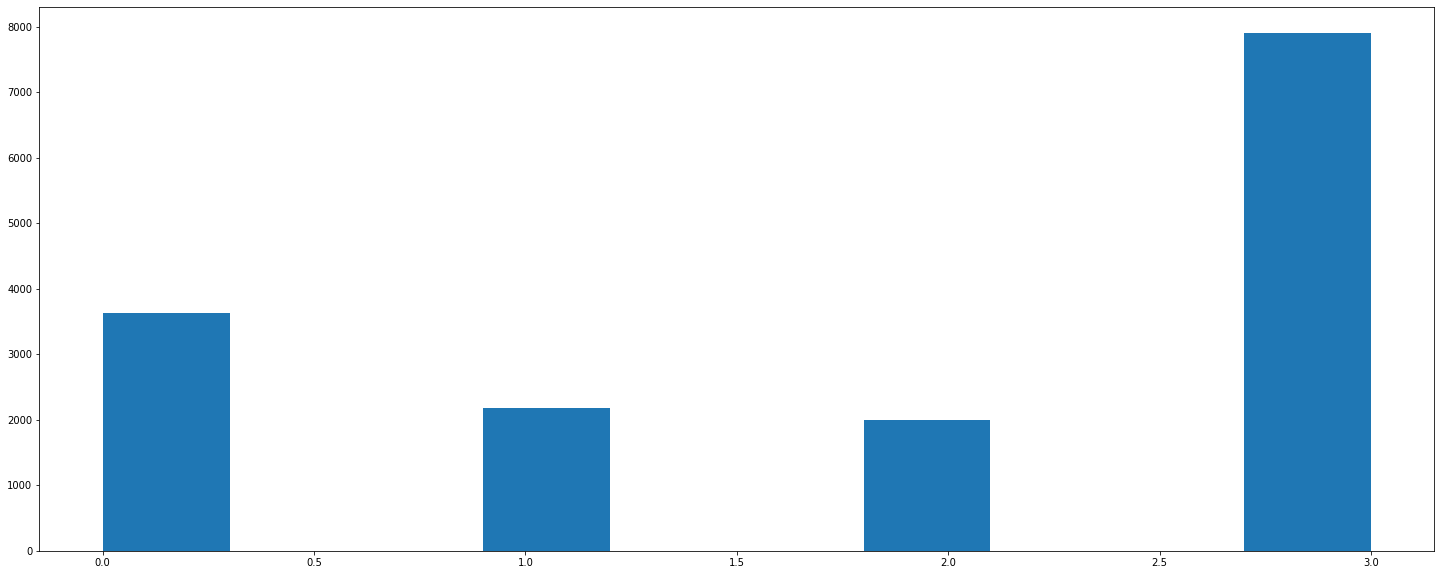

In [191]:
from collections import Counter
dist = Counter(y_train)
for k in dist:
    dist[k] /= len(y_train)
plt.hist(y_train)

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, pred)))

In [ ]:
pred = tres(pred, t).astype(int)
# pred = treshold(pred, percent).astype(int)

# pred = format(pred, X_train, df_data, y_train).astype(int)

In [194]:
pred = final_pred

In [ ]:
pred

(array([231.,   0.,   0., 139.,   0.,   0., 130.,   0.,   0., 500.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

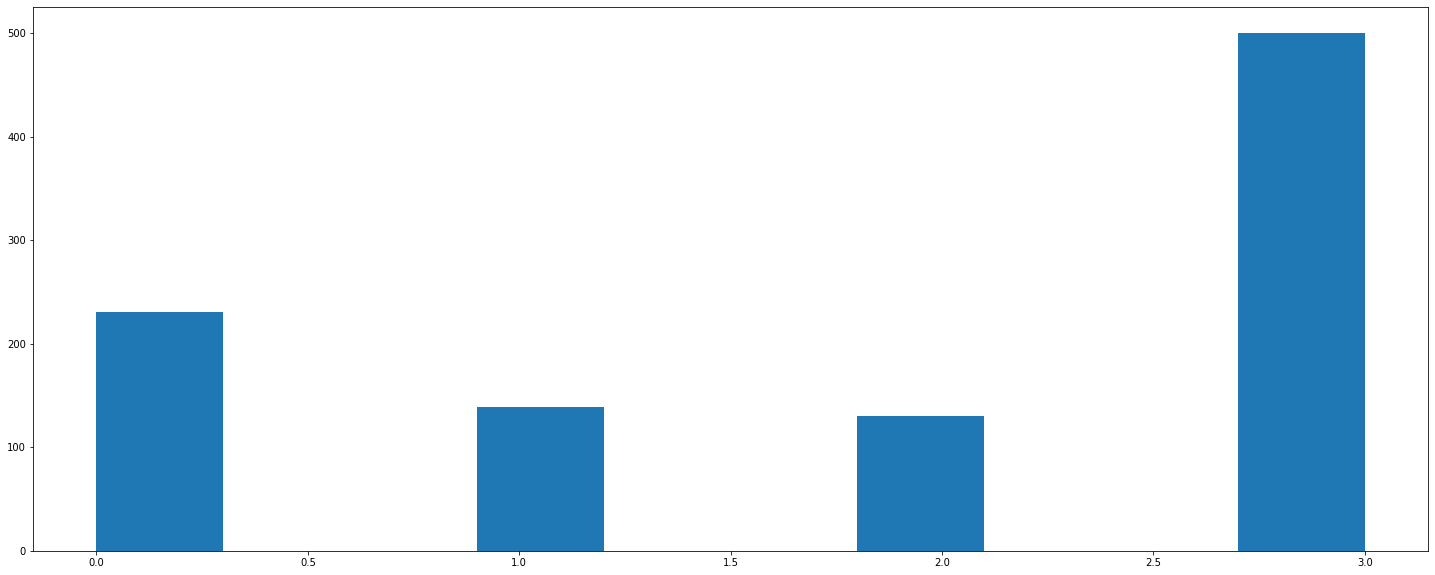

In [193]:
plt.hist(final_pred)

In [195]:
X = []
for i in range(len(pred)):
    X.append([ids[i], pred[i]])

In [196]:
pred = pd.DataFrame(X, columns = ['installation_id','accuracy_group'])

In [197]:
pred.index = pred['installation_id']

In [198]:
sample_sub = pd.read_csv(subs)
sample_sub['accuracy_group'] = pred.loc[sample_sub['installation_id'].values]['accuracy_group'].values

In [199]:
sample_sub.to_csv('submission1.csv', index = False)

In [200]:
sample_sub

,installation_id,accuracy_group
0,00abaee7,1
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,2
998,ffe00ca8,1
